/tmp/ipykernel_351319/3679987444.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


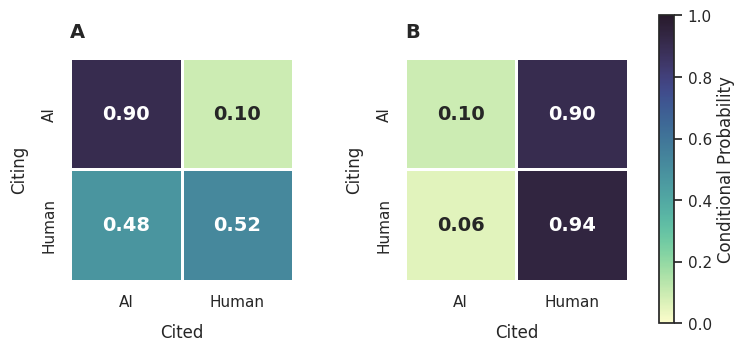

Coherence matrix: figure/coherence_matrix.png


/tmp/ipykernel_351319/3679987444.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


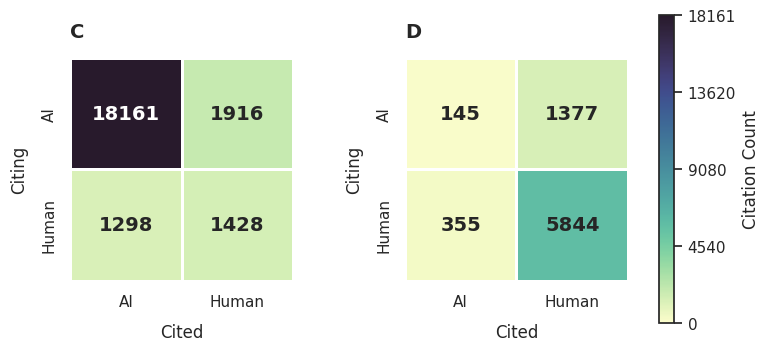

Citation count matrix: figure/coherence_matrix_counts.png


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cmocean
from matplotlib.colors import LogNorm

sns.set_theme(style="white")

def compute_citation_preference(citations_df, vote_results_df):
  
    vote_results_df = vote_results_df.rename(columns={'paper_id': 'pid', 'final_decision': 'decision'})
    
    citations_df = citations_df.merge(
        vote_results_df[['pid','decision']], 
        left_on='citing_paper_id', 
        right_on='pid', 
        how='left'
    ).rename(columns={'decision': 'citing_decision'}).drop('pid', axis=1)

    citations_df = citations_df.merge(
        vote_results_df[['pid','decision']], 
        left_on='cited_paper_id', 
        right_on='pid', 
        how='left'
    ).rename(columns={'decision': 'cited_decision'}).drop('pid', axis=1)

    citations_df = citations_df.dropna(subset=['citing_decision','cited_decision'])

    group_count = citations_df.groupby(['citing_decision','cited_decision']).size().reset_index(name='count')
    
    pivot_count = group_count.pivot(index='citing_decision', columns='cited_decision', values='count').fillna(0)
    
    for dec in ['AI','Human']:
        if dec not in pivot_count.index:
            pivot_count.loc[dec] = 0
        if dec not in pivot_count.columns:
            pivot_count[dec] = 0
    pivot_count = pivot_count.reindex(index=['AI','Human'], columns=['AI','Human'], fill_value=0)

    row_sum = pivot_count.sum(axis=1)
    fraction_df = pivot_count.div(row_sum, axis=0).fillna(0)

    return pivot_count, fraction_df


def plot_citation_counts(count_bad, count_good, outfile="coherence_matrix_counts.pdf"):
 
    mat_bad  = count_bad.values.astype(int)
    mat_good = count_good.values.astype(int)
    
    max_count = max(mat_bad.max(), mat_good.max())

    x_labels = ["AI", "Human"]  # Cited
    y_labels = ["AI", "Human"]  # Citing

    fig, (ax_l, ax_r) = plt.subplots(
        1, 2,
        figsize=(8, 4),
        gridspec_kw={'wspace': 0.5}
    )

    sns.heatmap(
        mat_bad,
        ax=ax_l,
        cmap=cmocean.cm.deep,
        vmin=0,
        vmax=max_count,
        square=True,
        annot=True,
        fmt="d",
        linewidths=1,
        linecolor="white",
        cbar=False,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot_kws={"fontsize":14, "weight":"bold"}
    )
    ax_l.set_title("C", loc="left", fontweight="bold", fontsize=14, pad=15)
    ax_l.set_xlabel("Cited", fontsize=12, labelpad=10)
    ax_l.set_ylabel("Citing", fontsize=12, labelpad=10)

    sns.heatmap(
        mat_good,
        ax=ax_r,
        cmap=cmocean.cm.deep,
        vmin=0,
        vmax=max_count,
        square=True,
        annot=True,
        fmt="d",
        linewidths=1,
        linecolor="white",
        cbar=False,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot_kws={"fontsize":14, "weight":"bold"}
    )
    ax_r.set_title("D", loc="left", fontweight="bold", fontsize=14, pad=15)
    ax_r.set_xlabel("Cited", fontsize=12, labelpad=10)
    ax_r.set_ylabel("Citing", fontsize=12, labelpad=10)

    cbar = fig.colorbar(
        ax_l.collections[0],
        ax=[ax_l, ax_r],
        orientation='vertical',
        fraction=0.05,
        pad=0.05
    )
    cbar.set_label("Citation Count", fontsize=12)
    ticks = [0, max_count//4, max_count//2, 3*max_count//4, max_count]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([str(t) for t in ticks])

    plt.tight_layout()
    plt.savefig(outfile,dpi=300)
    plt.show()
    plt.close()
    print(f"Citation count matrix: {outfile}")

def plot_coherence_matrices(frac_bad, frac_good, outfile="figure/coherence_matrix_seaborn.png"):
  
    mat_bad = frac_bad.values
    mat_good = frac_good.values
    
    x_labels = ["AI", "Human"]  # Cited
    y_labels = ["AI", "Human"]  # Citing

    fig, (ax_left, ax_right) = plt.subplots(
        1, 2, 
        figsize=(8, 4),
        gridspec_kw={'wspace': 0.5}  
    )

    sns.heatmap(
        mat_bad, 
        ax=ax_left,
        vmin=0, vmax=1,
        cmap=cmocean.cm.deep,           
        square=True,
        annot=True,
        fmt=".2f",
        linewidths=1,               
        linecolor="white",
        cbar=False,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot_kws={"fontsize": 14, "weight": "bold"}
    )
    ax_left.set_xlabel("Cited", fontsize=12, labelpad=10)
    ax_left.set_ylabel("Citing", fontsize=12, labelpad=10)
    ax_left.set_title("A",fontweight="bold", fontsize=14, pad=15, loc="left")

    sns.heatmap(
        mat_good,
        ax=ax_right,
        vmin=0, vmax=1,
        cmap=cmocean.cm.deep,   
        square=True,
        annot=True,
        fmt=".2f",
        linewidths=1,
        linecolor="white",
        cbar=False,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot_kws={"fontsize": 14, "weight": "bold"}
    )
    ax_right.set_xlabel("Cited", fontsize=12, labelpad=10)
    ax_right.set_ylabel("Citing", fontsize=12, labelpad=10)
    ax_right.set_title("B", fontsize=14, pad=15, loc="left",fontweight="bold")
    
    cbar = fig.colorbar(
        ax_left.collections[0],
        ax=[ax_left, ax_right],
        orientation='vertical',
        fraction=0.05,
        pad=0.05
    )
    cbar.set_label('Conditional Probability', fontsize=12)

    plt.tight_layout()
    plt.savefig(outfile,dpi=300)
    plt.show()
    plt.close()
    print(f"Coherence matrix: {outfile}")


if __name__ == "__main__":
    bad_citations_pkl = "data/pred/dataset/pkl/citations.pkl"
    bad_vote_pkl      = "data/pred/dataset/pkl/vote_results.pkl"
    
    good_citations_pkl = "data/norm/dataset/pkl/citations.pkl"
    good_vote_pkl      = "data/norm/dataset/pkl/vote_results.pkl"

    df_cit_bad  = pd.read_pickle(bad_citations_pkl)
    df_vote_bad = pd.read_pickle(bad_vote_pkl)

    df_cit_good  = pd.read_pickle(good_citations_pkl)
    df_vote_good = pd.read_pickle(good_vote_pkl)

    _, frac_bad   = compute_citation_preference(df_cit_bad,  df_vote_bad)
    _, frac_good  = compute_citation_preference(df_cit_good, df_vote_good)

    plot_coherence_matrices(frac_bad, frac_good, outfile="figure/coherence_matrix.png")

    count_bad, _  = compute_citation_preference(df_cit_bad,  df_vote_bad)
    count_good, _ = compute_citation_preference(df_cit_good, df_vote_good)

    plot_citation_counts(count_bad, count_good, outfile="figure/coherence_matrix_counts.png")

<h3>Chi-squre</h3>

In [3]:
from scipy.stats import chi2_contingency

bad_matrix = count_bad.values.astype(int)
good_matrix = count_good.values.astype(int)
chi2_bad, p_bad, _, _ = chi2_contingency(bad_matrix)
chi2_good, p_good, _, _ = chi2_contingency(good_matrix)

print("Predatory dataset chi-square p-value:", p_bad)
print("Regular dataset chi-square p-value:", p_good)


Predatory dataset chi-square p-value: 0.0
Regular dataset chi-square p-value: 9.303544385877394e-08


<h3>T-test</h3>

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

def compute_per_paper_dual_ratio(citations_df, vote_results_df):
    vote_results_df = vote_results_df.rename(columns={'paper_id': 'pid', 'final_decision': 'decision'})
    merged = (
        citations_df
        .merge(vote_results_df[['pid', 'decision']], left_on='citing_paper_id', right_on='pid', how='left')
        .rename(columns={'decision': 'citing_decision'})
        .drop('pid', axis=1)
        .merge(vote_results_df[['pid', 'decision']], left_on='cited_paper_id', right_on='pid', how='left')
        .rename(columns={'decision': 'cited_decision'})
        .drop('pid', axis=1)
        .dropna(subset=['citing_decision', 'cited_decision'])
    )

    merged['is_ai']    = merged['cited_decision'] == 'AI'
    merged['is_human'] = merged['cited_decision'] == 'Human'

    ai_ratio = merged.groupby(['citing_paper_id', 'citing_decision'])['is_ai'].mean()
    hu_ratio = merged.groupby(['citing_paper_id', 'citing_decision'])['is_human'].mean()

    ratio_df = pd.concat([ai_ratio, hu_ratio], axis=1).reset_index()
    ratio_df.columns = ['citing_paper_id', 'citing_decision', 'cite_ai_ratio', 'cite_human_ratio']
    return ratio_df

def run_paired_tests(ratio_df):
    print("=== Paired t-tests & Cohen’s d: within each citing group ===\n")
    for group in ['AI', 'Human']:
        sub = ratio_df[ratio_df['citing_decision'] == group]
        t_stat, p_val = ttest_rel(sub['cite_ai_ratio'], sub['cite_human_ratio'])
        diffs = sub['cite_ai_ratio'] - sub['cite_human_ratio']
        mean_diff = diffs.mean()
        sd_diff   = diffs.std(ddof=1)
        cohens_d  = mean_diff / sd_diff

        print(f"{group} citing group:")
        print(f"  Mean cite AI:    {sub['cite_ai_ratio'].mean():.3f}")
        print(f"  Mean cite Human: {sub['cite_human_ratio'].mean():.3f}")
        print(f"  Paired t-test: t = {t_stat:.3f}, p = {p_val:.5f}")
        print(f"  Mean difference (AI − Human) = {mean_diff:.3f}")
        print(f"  Cohen’s d (paired) = {cohens_d:.3f}\n")

ratio_bad = compute_per_paper_dual_ratio(df_cit_bad, df_vote_bad)
run_paired_tests(ratio_bad)

ratio_good = compute_per_paper_dual_ratio(df_cit_good, df_vote_good)
run_paired_tests(ratio_good)

=== Paired t-tests & Cohen’s d: within each citing group ===

AI citing group:
  Mean cite AI:    0.816
  Mean cite Human: 0.184
  Paired t-test: t = 51.296, p = 0.00000
  Mean difference (AI − Human) = 0.632
  Cohen’s d (paired) = 0.907

Human citing group:
  Mean cite AI:    0.455
  Mean cite Human: 0.545
  Paired t-test: t = -4.118, p = 0.00004
  Mean difference (AI − Human) = -0.089
  Cohen’s d (paired) = -0.092

=== Paired t-tests & Cohen’s d: within each citing group ===

AI citing group:
  Mean cite AI:    0.097
  Mean cite Human: 0.898
  Paired t-test: t = -49.989, p = 0.00000
  Mean difference (AI − Human) = -0.802
  Cohen’s d (paired) = -1.378

Human citing group:
  Mean cite AI:    0.061
  Mean cite Human: 0.928
  Paired t-test: t = -132.538, p = 0.00000
  Mean difference (AI − Human) = -0.867
  Cohen’s d (paired) = -1.814



<h3>z-test for AI ratio in both datasets</h3>

In [5]:
import pandas as pd
import math
from statsmodels.stats.proportion import proportions_ztest

def run_ai_ratio_with_effect_size(vote_pred, vote_reg):
    total_pred = len(vote_pred)
    total_reg  = len(vote_reg)
    ai_pred =    (vote_pred['final_decision'] == 'AI').sum()
    ai_reg  =    (vote_reg['final_decision'] == 'AI').sum()
    p1 = ai_pred / total_pred
    p2 = ai_reg  / total_reg

    print(f"Predatory: {ai_pred}/{total_pred} = {p1:.3%}")
    print(f"Regular:   {ai_reg}/{total_reg} = {p2:.3%}")

    # One‐sided z‐test
    zstat, pval = proportions_ztest([ai_pred, ai_reg], [total_pred, total_reg], alternative='larger')
    print(f"One-sided z-test: z = {zstat:.3f}, p = {pval:.5f}")

    # Cohen's d
    sd1 = math.sqrt(p1 * (1 - p1))
    sd2 = math.sqrt(p2 * (1 - p2))
    pooled_sd = math.sqrt((sd1**2 + sd2**2) / 2)
    cohens_d = (p1 - p2) / pooled_sd
    print(f"Cohen's d = {cohens_d:.3f}")

vote_pred = pd.read_csv("data/pred/dataset/csv/vote_results.csv")
vote_reg  = pd.read_csv("data/norm/dataset/csv/vote_results.csv")
run_ai_ratio_with_effect_size(vote_pred, vote_reg)


Predatory: 4162/6604 = 63.022%
Regular:   1388/7300 = 19.014%
One-sided z-test: z = 52.915, p = 0.00000
Cohen's d = 1.000
